In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, Point, MultiPolygon, MultiPoint
import shapely

import time

import requests

In [2]:
import hashlib
import hmac
import base64
import urllib.parse as urlparse


def sign_url(input_url=None, secret=None):
    """ Sign a request URL with a URL signing secret.
      Usage:
      from urlsigner import sign_url
      signed_url = sign_url(input_url=my_url, secret=SECRET)
      Args:
      input_url - The URL to sign
      secret    - Your URL signing secret
      Returns:
      The signed request URL
  """

    if not input_url or not secret:
        raise Exception("Both input_url and secret are required")

    url = urlparse.urlparse(input_url)

    # We only need to sign the path+query part of the string
    url_to_sign = url.path + "?" + url.query

    # Decode the private key into its binary format
    # We need to decode the URL-encoded private key
    decoded_key = base64.urlsafe_b64decode(secret)

    # Create a signature using the private key and the URL-encoded
    # string using HMAC SHA1. This signature will be binary.
    signature = hmac.new(decoded_key, str.encode(url_to_sign), hashlib.sha1)

    # Encode the binary signature into base64 for use within a URL
    encoded_signature = base64.urlsafe_b64encode(signature.digest())

    original_url = url.scheme + "://" + url.netloc + url.path + "?" + url.query

    # Return signed URL
    return original_url + "&signature=" + encoded_signature.decode()

In [13]:
def create_link(pic_base, api_key, x, y, radius, heading, signature, if_signature):

    def_link = pic_base+'key='+api_key+'&'+'location='+str(y)+','+str(x)+'&'+'radius='+str(radius)+'&'+'heading='+str(heading)+'&size=640x640&fov=120&source=outdoor'

    if if_signature:

        def_link = sign_url(def_link, signature)

    return def_link


In [14]:
meta_base = 'https://maps.googleapis.com/maps/api/streetview/metadata?'
pic_base = 'https://maps.googleapis.com/maps/api/streetview?'
api_key = 

signature = 

In [15]:
def get_streetview_api(x, y, api_key, resolution, area_bound, subscript):

    for radius in [100, 500, 1000, 2000, 10000, 30000, 50000]:

        meta_params = {'key': api_key, 'location': str(y)+','+str(x), 'radius':str(radius), 'fov':str(120), 'source':'outdoor'}
        meta_response = requests.get(meta_base, params=meta_params).json()

        if meta_response['status'] == 'OK':
            y, x = tuple(meta_response['location'].values())
            break
    
    if meta_response['status'] != 'OK' or not Point(x, y).within(area_bound):
        return [], ()

    pic_params = {'key': api_key,
                  'location': str(y)+','+str(x),
                  'size': resolution,
                  'fov':str(120),
                  'radius':str(radius),
                  'source':'outdoor'}
    
    metadata = []#(x, y, radius)
    result = []

    for heading in [120, 240, 360]:

        pic_params['heading'] = heading

        response = requests.get(create_link(pic_base, api_key, x, y, radius, heading, signature, True)) # pic_base, params=pic_params
        if response.status_code == 200:
            result.append(response.content)
            response.close()
            metadata.append((x, y, radius, heading, subscript))
        elif response.status_code == 403:
            print(response)
    
    return result, metadata   

In [16]:
class StreetViewData:
    def __init__(self, european_shape_file, n_locations=25000):
        self.EU_shapefile = gpd.read_file(european_shape_file)

        self.EU_shapefile_bbox = self.EU_shapefile

        self.n_locations = n_locations

        self.custom_geometries = {}
    
    def bound_map(self, cords):
        polys_b = gpd.GeoSeries([Polygon([x for x in cords])])
        self.df_b = gpd.GeoDataFrame({'geometry': polys_b}, crs='EPSG:4326')

        self.EU_shapefile_bbox = self.EU_shapefile.overlay(self.df_b, how='intersection')

    def get_areas(self, agg_level):

        self.subset_level = self.EU_shapefile_bbox.loc[self.EU_shapefile_bbox['LEVL_CODE']==agg_level]
        self.areas_m = self.subset_level.to_crs({'init': 'epsg:32633'})
        self.areas_m["area"] = self.areas_m['geometry'].area/ 10**6

        print('Average 1 location per ', (self.areas_m['area'].sum()/self.n_locations)**(1/2), 'km')

        self.custom_geometries['S'] = self.areas_m[['geometry', 'area', 'CNTR_CODE', 'NAME_LATN']].copy()

    def select_points(self, prop=None):

        total = self.areas_m['area'].sum()
        
        if prop is None:
            prop = self.areas_m['area']/total

        points_per_geo = (self.n_locations*prop).astype(int) + 1

        self.areas_m['sampled'] = self.areas_m.sample_points(points_per_geo)

        self.areas_m['sampled'] = self.areas_m['sampled'].to_crs({'init': 'EPSG:4326'})
        self.areas_m['geometry'] = self.areas_m['geometry'].to_crs({'init': 'EPSG:4326'})

    def download_streetview_data(self, api_key, regions=[], subscript='S'):

        if not os.path.exists('DATA'):
            os.mkdir('DATA')

        for _, row in self.areas_m.iterrows():

            if row['CNTR_CODE'] not in regions:
                continue

            subregion_folder = 'DATA/'+row['CNTR_CODE']+'/'+row['NAME_LATN'].replace('/', '_') + '/'
            if not os.path.exists(subregion_folder):
                os.makedirs(subregion_folder)

            if type(row['sampled']) is shapely.geometry.point.Point:

                x = row['sampled'].x
                y = row['sampled'].y

                # ======
                try:
                    res, meta = get_streetview_api(x, y, api_key, '640x640', row['geometry'], subscript)
                    if len(meta) > 0:
                        for i, f in enumerate(res):
                            with open(subregion_folder+'%s|%s|%s|%s|%s.jpg' % meta[i], 'wb') as file:
                                file.write(f)
                except:
                    time.sleep(5)
                    print('ups', row['CNTR_CODE'])
                # ======

            else:
                for point in row['sampled'].geoms:
                    
                    try:
                        x = point.geoms.x
                        y = point.geoms.y
                    except:
                        x = point.x
                        y = point.y

                    # ======
                    try:
                        res, meta = get_streetview_api(x, y, api_key, '640x640', row['geometry'], subscript)
                        if len(meta) > 0:
                            for i, f in enumerate(res):
                                with open(subregion_folder+'%s|%s|%s|%s|%s.jpg' % meta[i], 'wb') as file:
                                    file.write(f)
                    except:
                        time.sleep(5)
                        print('ups', row['CNTR_CODE'])
                    # ======
    def load_custom_geometry(self, geom, n_locations=None, subscript='U'):

        if n_locations is not None:
            self.n_locations = n_locations

        self.areas_m = gpd.sjoin(geom, self.subset_level.to_crs({'init': 'epsg:32633'}))

        def agg_polygons(vars):
            return MultiPolygon(vars.values)

        x1 = self.areas_m.groupby(
            ['CNTR_CODE', 'NAME_LATN']).apply(
                lambda x: (x['area'].sum(), agg_polygons(x['geometry']))).reset_index()

        area, geometry = zip(*x1[0])

        self.areas_m = gpd.GeoDataFrame(data={
            'CNTR_CODE':x1['CNTR_CODE'], 
            'NAME_LATN':x1['NAME_LATN'], 
            'area':area}, geometry=np.array(geometry), crs='epsg:32633')

        self.custom_geometries[subscript] = self.areas_m
        
        print('Average 1 location per ', (self.areas_m['area'].sum()/self.n_locations)**(1/2), 'km')

    def load_downloaded_cords(self):

        self.data_cords_contrainer = {}

        for name_ in glob.glob('DATA/*/*/*120|*.jpg'):

            _, country_, region_, cords = name_.split('/')
            cords = Point([float(x) for x in cords.split('|', )[:2]])
            subtype = name_.rsplit('|', 1)[1].split('.')[0]

            if country_ not in self.data_cords_contrainer:
                self.data_cords_contrainer[country_] = {}

            if region_ not in self.data_cords_contrainer[country_]:
                self.data_cords_contrainer[country_][region_] = {}

            if subtype not in self.data_cords_contrainer[country_][region_]:
                self.data_cords_contrainer[country_][region_][subtype] = []

            self.data_cords_contrainer[country_][region_][subtype].append(cords)

        self.data_cords_contrainer_ = {}
        for k_c in self.data_cords_contrainer:
            self.data_cords_contrainer_[k_c] = {}
            for k_r in self.data_cords_contrainer[k_c]:
                self.data_cords_contrainer_[k_c][k_r] = {}
                for k_t in self.data_cords_contrainer[k_c][k_r]:
                    self.data_cords_contrainer_[k_c][k_r][k_t] = MultiPoint(self.data_cords_contrainer[k_c][k_r][k_t])
        
        self.data_cords_contrainer = pd.concat({k: pd.DataFrame(v).T for k, v in self.data_cords_contrainer_.items()}, axis=0)
    
        return self.data_cords_contrainer
    
    def plot_downloaded_shapefiles(self, suffixes='ALL'):

        if suffixes == 'ALL':
            suffixes = [x for x in list(self.custom_geometries.keys()) if x != 'S']

        ax = self.custom_geometries['S'].plot()

        for suff in suffixes:
            self.custom_geometries[suff].plot(ax=ax, color='red')
        plt.show()

In [17]:
Data = StreetViewData('DATA_OTHER/NUTS_RG_20M_2021_4326.shp', 10000)
Data.bound_map([(-13.653748, 35.879978), (37.353218, 35.917920), (30.936364, 65.165650), (-10.937123, 65.209358)])
Data.get_areas(2)
Data.select_points()

total = Data.areas_m['area'].sum()
preserve = Data.areas_m['area']/total

Average 1 location per  22.587875988084395 km


/home/krzysztof-kalisiak/Desktop/ROCM_repo/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/krzysztof-kalisiak/Desktop/ROCM_repo/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
CSF = gpd.read_file('DATA_OTHER/eea_v_3035_100_k_umz-2000_p_2013_v16_r00')
CSF = CSF.to_crs({'init': 'epsg:32633'})
CSF["area"] = CSF['geometry'].area/ 10**6

Data.load_custom_geometry(CSF, 10000, subscript='v')

Data.select_points(prop=preserve)

d = Data.areas_m.copy()
d['n_points'] = d.sampled.explode(index_parts=True).groupby(level=0).count()

d1 = d.groupby('CNTR_CODE')['n_points'].sum() / Data.subset_level.groupby('CNTR_CODE').apply(lambda x: np.sum(x.area))
preserve = preserve * Data.areas_m.join(pd.Series(100/d1, name='multiplier'), on='CNTR_CODE')['multiplier'].values

preserve = preserve / preserve.sum()

Data.select_points(prop=preserve)

/home/krzysztof-kalisiak/Desktop/ROCM_repo/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/krzysztof-kalisiak/Desktop/ROCM_repo/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_230315/2881887732.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and

Average 1 location per  5.114634360149552 km


/home/krzysztof-kalisiak/Desktop/ROCM_repo/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_230315/237826601.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  d1 = d.groupby('CNTR_CODE')['n_points'].sum() / Data.subset_level.groupby('CNTR_CODE').apply(lambda x: np.sum(x.area))
/tmp/ipykernel_230315/237826601.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operatio

In [28]:
Data.download_streetview_data(api_key, ['HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK',
       'TR', 'UK'], 'v')

In [8]:
import glob
len(glob.glob('DATA/*/*/*.jpg')) + len(glob.glob('storage/*/*/*.jpg'))

183402

In [19]:
axs = Data.load_downloaded_cords()

/home/krzysztof-kalisiak/Desktop/ROCM_repo/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


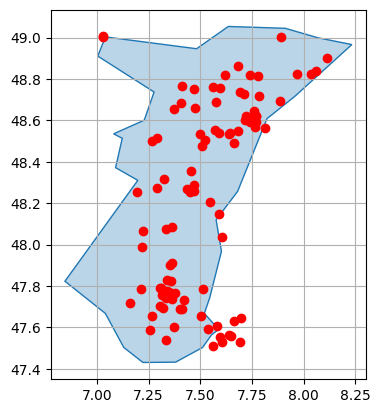

In [36]:
from shapely.plotting import plot_points, plot_polygon

c_iso = 'FR'
region = 'Alsace'

fig, ax = plt.subplots()
cells = plot_points(axs.loc[(c_iso, region), 'v'], color='Red')
bounds = plot_polygon(Data.custom_geometries['S'].loc[Data.custom_geometries['S']['NAME_LATN']==region, 'geometry'].to_crs({'init': 'EPSG:4326'}).iloc[0], add_points=False)